In [1]:
import pandas as pd
import numpy as np
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import panel as pn
pn.extension('tabulator')
pn.extension(template='fast-list')
from matplotlib.backends.backend_agg import FigureCanvas
import hvplot.pandas
from ipywidgets import Dropdown

In [2]:
from datetime import date
from math import ceil
from matplotlib.figure import Figure
# not needed for mpl >= 3.1
from matplotlib.backends.backend_agg import FigureCanvas

In [3]:
from panel.interact import interact

In [4]:

df = pd.DataFrame

In [5]:
yaxis_share = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['High', 'Close', 'Low'],
    button_type='success'
)


In [6]:
tickers = ['AAPL', 'FB', 'GOOG', 'IBM', 'MSFT']
start = pn.widgets.DatePicker(name='Start Date', value=date(2020,1,1), start=date(2015,1,1), end=date.today())
end = pn.widgets.DatePicker(name='End Date', value=date(2022,1,1), start=date(2015,1,1), end=date.today())
df_widget = None
def get_df(ticker, window_size, start , end):
    global df
    df = web.DataReader(ticker, data_source="yahoo", start=start, end=end )
    df['Date'] = pd.to_datetime(df.index)
    
    return df.set_index('Date').rolling(window=window_size).mean().reset_index()

def get_plot(ticker, share_values,window_size, start , end ):
    df = get_df(ticker, window_size, start=start , end=end)
    global df_widget
    df_widget = pn.widgets.Tabulator(df, height=300)
    return df.hvplot.line('Date', share_values , grid=True, height=300, width=700)

# 

In [7]:
interact = pn.interact(get_plot, ticker=tickers, share_values = yaxis_share, start = start , end = end ,window_size=(1, 21, 5)  )

In [8]:

# jpg_pane = pn.pane.JPG('stock.jpg', width=500)

In [9]:

df.head(5)

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2019-12-31,73.419998,72.379997,72.482498,73.412498,100805600.0,72.139954,2019-12-31
2020-01-02,75.150002,73.797501,74.059998,75.087502,135480400.0,73.785912,2020-01-02
2020-01-03,75.144997,74.125000,74.287498,74.357498,146322800.0,73.068573,2020-01-03
2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,73.650795,2020-01-06
2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.304420,2020-01-07


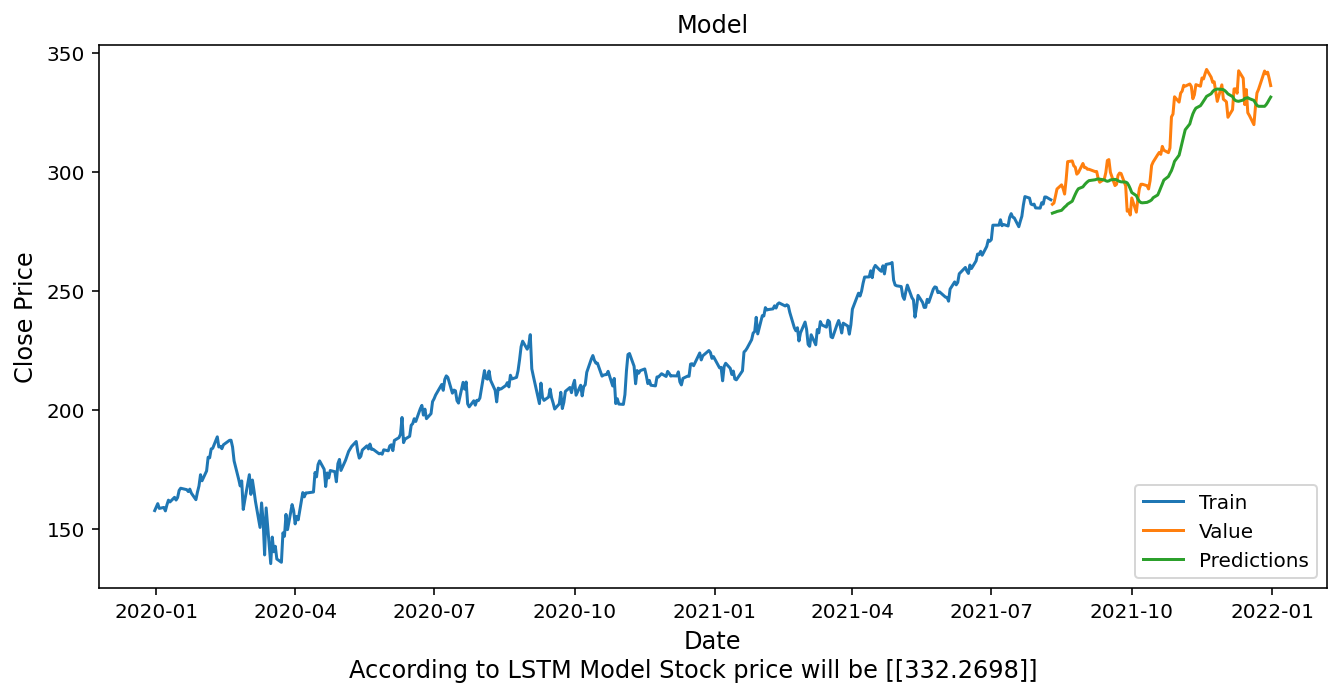

In [56]:
html_pane = pn.pane.HTML(
    """ArithmeticError"""
)
def prediction(ticker):
    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = ceil(len(dataset) * .8)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60: i, 0])
        y_train.append(train_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train , (x_train.shape[0], x_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60,len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean( predictions - y_test )** 2 )
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    fig = plt.figure(figsize = (11, 5))
    plt.title('Model')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Train', 'Value', 'Predictions'],loc='lower right')
    pn.pane.Matplotlib(fig)
    apple_quote = df
    new_df = apple_quote.filter(['Close'])
    last_60_days = new_df[-60:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    txt=f"According to LSTM Model Stock price will be {pred_price}"
    plt.figtext(0.5, 0.001, txt, wrap=True, horizontalalignment='center', fontsize=12)
    global html_pane
    html_pane =  pn.widgets.TextInput(name='A widget', value=txt, readonly=1 )
    return fig

In [48]:
# interact2 = pn.interact(pred_price_stock,df)


345/345 [==============================] - 51s 106ms/step - loss: 0.0039


C:\Users\Shubham\AppData\Local\Temp\ipykernel_3004\2411955002.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


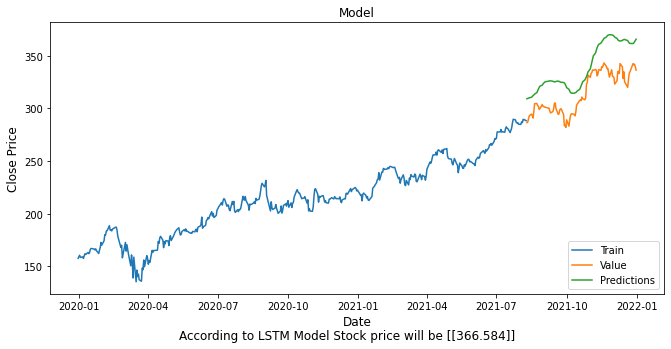

In [57]:
interact1 = pn.interact(prediction, ticker = pn.widgets.Button(name='Show Prediction Analysis',button_type='success'), window_size=(1, 21, 5))

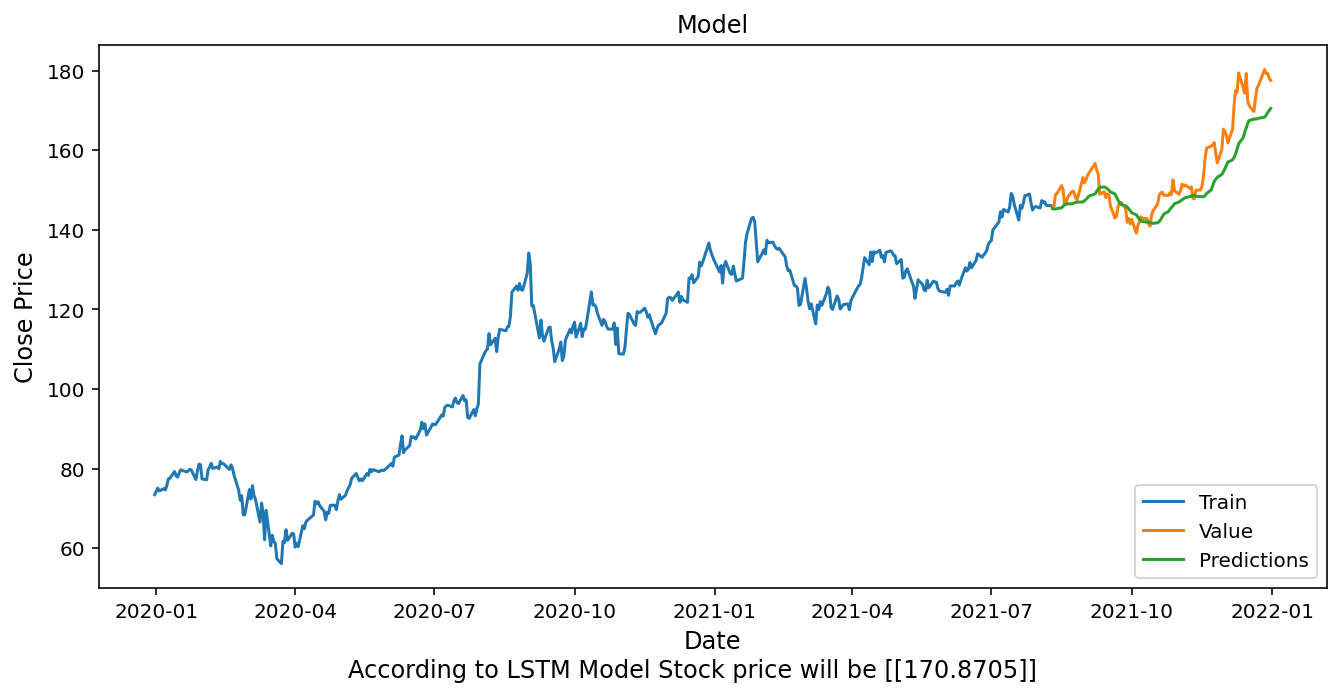

In [64]:
def showPredicationResult(ticker):
    global html_pane
    return html_pane

In [68]:
interact2 = pn.interact(showPredicationResult, ticker = pn.widgets.Button(name='Show Prediction Result',button_type='success') , window_size=(1, 21, 5))

In [69]:
interact2[1]

BokehModel(combine_events=True, render_bundle={'docs_json': {'b716c267-c917-4ea9-b9ed-19fdd6a785ad': {'defs': …

Row
    [0] TextInput(name='A widget', value='According to L...)

In [70]:
import holoviews as hv

name  = pn.pane.HTML("""
 <div class="tradingview-widget-container">
    <div id="tradingview_04098"></div>
    <div class="tradingview-widget-copyright"><a href="https://in.tradingview.com/symbols/NASDAQ-AAPL/" rel="noopener" target="_blank"><span class="blue-text">AAPL Chart</span></a> by TradingView</div>
      <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script> 
    <script type="text/javascript">
    $(document).ready(function() {
    new TradingView.widget(
    {
    "width": 1000,
    "height": 600,
    "symbol": "NASDAQ:AAPL",
    "timezone": "Etc/UTC",
    "theme": "light",
    "style": "1",
    "locale": "in",
    "toolbar_bg": "#f1f3f6",
    "enable_publishing": true,
    "withdateranges": true,
    "range": "YTD",
    "hide_side_toolbar": false,
    "allow_symbol_change": true,
    "details": true,
    "hotlist": true,
    "calendar": true,
    "show_popup_button": true,
    "popup_width": "1000",
    "popup_height": "650",
    "container_id": "tradingview_04098"
  }
    );
    });
    </script>
  </div>
""",  style={'background-color': '#000'}
)

In [71]:
# pn.extension('vega', 'katex')
js_files = {'jquery': 'https://code.jquery.com/jquery-1.11.1.min.js',
'tradingview': 'https://s3.tradingview.com/tv.js'
}
pn.extension(js_files=js_files)


In [72]:
template = pn.template.FastListTemplate(
    title='Stock Market Prediction', 
    sidebar=[pn.pane.Markdown("# Stock Market Prediction"), 
             pn.pane.Markdown("#### The intelligent investor is a realist who sells to optimists and buys from pessimists."), 
             # jpg_pane,
             pn.pane.Markdown("## Settings"),   
             interact[0] ],
    main=[
        # pn.Row(pn.Column(yaxis_share, 
        #                    share_plot.panel(width=700), margin=(0,25)), 
        #          share_table.panel(width=500)),
        pn.Row(pn.Column(name)),
        pn.Row(pn.Column(interact[1]),
             pn.Column(df_widget)
              ),
              pn.Row(
              pn.Column(interact1[0],interact1[1])
              ),
              pn.Row(pn.Column(interact2[0],interact2[1])
              )
   ],
       
    accent_base_color="#88d8b0",
    header_background="#88d8b0",
)
# template.show()


In [73]:
template.servable()
template.show()

Launching server at http://localhost:53071


345/345 [==============================] - 47s 104ms/step - loss: 0.0031


C:\Users\Shubham\AppData\Local\Temp\ipykernel_3004\2411955002.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [83]:
def page1():
    template = pn.template.FastListTemplate(
    title='Stock Market Prediction', 
    sidebar=[pn.pane.Markdown("# Stock Market Prediction"), 
             pn.pane.Markdown("#### The intelligent investor is a realist who sells to optimists and buys from pessimists."), 
             # jpg_pane,
             pn.pane.Markdown("## Settings"),   
             interact[0] ],
    main=[
        # pn.Row(pn.Column(yaxis_share, 
        #                    share_plot.panel(width=700), margin=(0,25)), 
        #          share_table.panel(width=500)),
        pn.Row(pn.Column(name)),
        pn.Row(pn.Column(interact[1]),
             pn.Column(df_widget)
              ),
              pn.Row(
              pn.Column(interact1[0],interact1[1])
              ),
              pn.Row(pn.Column(interact2[0],interact2[1])
              )
   ],
       
    accent_base_color="#88d8b0",
    header_background="#88d8b0",
)
    return template

def page2():
    return pn.Column(
        "# Page 2", "Welcome to the second page"
    )
ROUTES = {
    "1": page1, "2": page2
}
pn.serve(ROUTES, port=50032)

Launching server at http://localhost:50032


In [87]:
pn.template.FastListTemplate(
    site="Panel", 
    title="Sync Location", 
    main=[
        "This example demonstrates **how to sync widget state with the URL bar**. The widgets values are set from the URL parameters on page load and the URL parameters are set when a widget value changes.",
        pn.Column('tdytfy'),
    ], main_max_width="768px",
).servable().show()

Launching server at http://localhost:53389
